In [1]:
# 저장하지 않고 다트가져오기+시각화 => 시간 너무 오래 걸려서 포기. 나중에 시간 많을 때 해볼 것

In [1]:
import requests
import pandas as pd
import numpy as np
from io import BytesIO
import re
import os
from zipfile import ZipFile
import xmltodict
import json
import matplotlib.pyplot as plt

api_key = '7d523a1a3ce98201eb9eeb5c04c206363c176810'
url_corp = 'https://opendart.fss.or.kr/api/corpCode.xml?crtfc_key={}'.format(api_key)
resp_corp = requests.get(url_corp)

zf_corp = ZipFile(BytesIO(resp_corp.content))
zf_corp_name = zf_corp.namelist()
zf_corp_name_pop = zf_corp_name.pop()

data_xml = zf_corp.read(zf_corp_name_pop).decode('utf-8')
data_odict = xmltodict.parse(data_xml)
data_dict = json.loads(json.dumps(data_odict))
data = data_dict.get('result', {}).get('list')


In [2]:
def dart_data_10q(corp_name, fs_type, fs_item):
    where_name = (item for item in data if item['corp_name'] == corp_name)
    # corp_name 이 corp_name인 dict를 list에서 가져오기
    # 만약 값이 없을 경우 false가 dict에 저장됨
    dict_name = next(where_name, False)
    corp_code = dict_name['corp_code']

    print(corp_code)
    print(' ')
    
    url_info = 'https://opendart.fss.or.kr/api/list.xml?crtfc_key={}&corp_code={}&bgn_de=19990101&last_reprt_at=N&pblntf_detail_ty=A001&pblntf_detail_ty=A002&pblntf_detail_ty=A003'.format(api_key, corp_code)
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.67 Safari/537.36 Edg/87.0.664.47'
    headers = {'user-agent' : user_agent}

    resp = requests.get(url_info)
    resp_decode = resp.content.decode('utf-8')

    period = re.findall(r'<report_nm>(.*?)</report_nm>', resp_decode)
    rcp = re.findall(r'<rcept_no>(.*?)</rcept_no>', resp_decode)
    # <report_nm> 이런건 미리 해보고 알 수 있는 것들

    dcm = []

    for i in range(len(rcp)):
        url_rcp = 'http://dart.fss.or.kr/dsaf001/main.do?rcpNo=' + rcp[i]
        resp_rcp = requests.get(url_rcp, headers = headers)
        resp_rcp_decode = resp_rcp.content.decode('utf-8')
        dcm_i = re.findall(rcp[i]+"', '(.*?)',", resp_rcp_decode)[0]
        dcm = dcm + [dcm_i]
        
    dict2_info = dict(zip(zip(period, rcp),dcm))
    
    print(period[0])
    print(rcp[0])
    print(dcm[0])
    print(' ')
    
    for i in range(min(len(period), len(rcp), len(dcm))):
        url_rcpdcm = 'http://dart.fss.or.kr/pdf/download/excel.do?rcp_no='+rcp[i]+'&dcm_no='+dcm[i]+'&lang=ko'
               
        resp_rcpdcm = requests.get(url_rcpdcm, headers = headers)
        output = BytesIO(resp_rcpdcm.content)
        sheet_name_s = list(pd.read_excel(output, sheet_name = None).keys())

    print(sheet_name_s)
    print(' ')
    
    period_s = []
    rev_s = []  
    
    for i in range(len(period)):
        period_i = re.findall(r'{}(.*?){}'.format('보고서 \(','\)'), period[i])[0]
        period_s.append(period_i)
    
    for i in range(min(len(period), len(rcp), len(dcm))):
        url_rcpdcm = 'http://dart.fss.or.kr/pdf/download/excel.do?rcp_no='+rcp[i]+'&dcm_no='+dcm[i]+'&lang=ko'
               
        resp_rcpdcm = requests.get(url_rcpdcm, headers = headers)
        output = BytesIO(resp_rcpdcm.content)

        df = pd.read_excel(output, sheet_name = fs_type)
        df1 = df.apply(lambda x : x.str.contains(fs_item), axis = 1)
        
        if df1.sum().sum() == 1 :
            
            col = df1.sum(axis = 0).values.argmax()
            row = df1.sum(axis = 1).values.argmax()
            rev = df.iloc[row, col+1]
            rev_s.append(rev)
            
        else:
            print('error '+str(df1.sum().sum()))
    
    print(df)
    print(' ')
    
    print(period_s)
    print(rev_s)
    print(' ')
    
    period_ss = list(map(float, period_s))
    rev_ss = list(map(int, rev_s))
    rev_table = dict(zip(period_ss, rev_ss))
    rev_table_sort = sorted(rev_table.items())
    
    period_sss = []
    rev_sss = []

    for i in range(len(rev_table_sort)):
        period_sss_i = rev_table_sort[i][0]
        rev_sss_i = rev_table_sort[i][1]

        period_sss.append(str('%.2f'%period_sss_i))
        rev_sss.append(rev_sss_i)

    rev_table_sorted = dict(zip(period_sss, rev_sss))
    
    x_s = period_sss
    y_s = rev_sss

    plt.bar(x_s, y_s)
    plt.xlabel('Period')
    plt.ylabel('Revenue')
    plt.show()
    
    return rev_table_sorted    

00266961
 
분기보고서 (2020.09)
20201113000918
7545316
 
['기본정보', '연결 재무상태표', '연결 포괄손익계산서', '연결 자본변동표', '연결 현금흐름표', '재무상태표', '포괄손익계산서', '자본변동표', '현금흐름표']
 
                                Unnamed: 0      Unnamed: 1      Unnamed: 2  \
0                               연결 포괄손익계산서             NaN             NaN   
1   제 20 기 3분기 2018.01.01 부터 2018.09.30 까지             NaN             NaN   
2   제 19 기 3분기 2017.01.01 부터 2017.09.30 까지             NaN             NaN   
3                                 (단위 : 원)             NaN             NaN   
4                                               제 20 기 3분기             NaN   
5                                      NaN             3개월              누적   
6                                영업수익 (주8)   1397713834674   4070389652254   
7                                     영업비용  -1175995432109  -3341107496540   
8                                 영업이익(손실)    221718402565    729282155714   
9                                     기타수익     18045330769    1577444

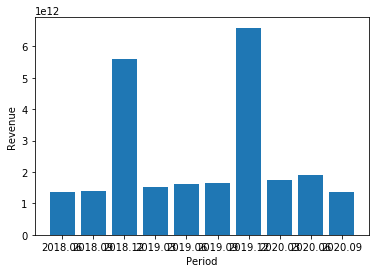

{'2018.06': 1363615953332,
 '2018.09': 1397713834674,
 '2018.12': 5586904533355,
 '2019.03': 1510861770282,
 '2019.06': 1630275004395,
 '2019.09': 1664815000078,
 '2019.12': 6593400065244,
 '2020.03': 1732064462097,
 '2020.06': 1902467957491,
 '2020.09': 1360779374259}

In [9]:
dart_data_10q('NAVER', '연결 포괄손익계산서', '영업수익')